# First day IPO  Stock Price Prediction : Can we use Machine Learning to outsmart the market ?

Creating perfect value propositions by combining different products, customer behaviours and diverse channels is one the major challenges in the Banking Industry. **Financial Engineers** who master the art of knowing **"what to sell, when and to whom"** have gathered a lot of interest in the last decades. 

However, with the exponential spread of data accessible to everyone, the proliferation of misleading information has made it a challenge to rightfully **identify valuable information**. Because banks need to have strong and quality intelligence, operating models where an army of analysts are responsible to mine data manually and produce insights become inefficient (time and money) and led to an increase in the demand for **automated tools** to produce personalised product offering as the key for the next generation banking.

In this scenario, we place ourselves as **external consultant for an investment bank** who would like to know if they should use Machine Learning to more accurately price IPOs, in particular the first-day IPO stock.

In this context, the **challenge** is double for the investment bank reputation: 
- Setting a price too low in comparison to the price of the stock at the end of the day is not in the interest of the issuing company as it wants an accurate prediction because that helps them maximize the amount of capital that they can raise from the IPO
- Conversely, overpricing the IPO can lead to a rapid fall in prices, which will hurt the reputation and future prospects of the bank.

Using machine learning for economical models may be interesting for this kind of scenario as it is able, when done properly, to tell us how things would look like given previous experience and how likely is a given outcome. Accurately pricing IPOs means determing how good is the issuing company in its domain and how suitable its business model is for the market, among other factors as well which may be harder to quantify.

In this project, we will explore different approaches and try out different machine learning models to provide a strategic support and diagnosis to determine in the best way possible if **investment banks should change their internal operating mode** to price IPOs by making the following predictions.

<img src="images/image_p.png" style="height:300px">

#### Table of contents
* [1. Imports and helper functions](#EDA)

* [2. Feature Engineering](#FE)
 * [2.1 Data Preprocessing functions](#FE1)
 * [2.3 Text Processing functions](#FE2)
 * [2.3 Training data and validation data](#FE3)


* [3.: Models](#ML1)
    * [3.1 Logisticregression](#ML1.2)
    * [3.2 RANDOM Forest](#ML1.2)
    * [3.3 WORD2VEC](#ML1.1)
    * [3.4 Ensemble](#ML1.1)
    * [3.5 Linear Regression](#ML1.1)
    
 * [4. Predictions](#ML2)
    * [4.1 P1](#ML2.2.1)
    * [4.2 P2](#ML2.2.1)
    * [4.3 P3](#ML2.2.1)
    * [4.4 P4](#ML2.2.1)
    * [4.5 P5](#ML2.2.1)
    * [4.6 P6](#ML2.2.1)
    * [4.7 P7](#ML2.2.1)
    * [4.8 P8](#ML2.2.1)
    * [4.9 P9](#ML2.2.1)
    
* [5. Results](#Concl)

* [6. Conclusion](#Concl)

## 1. Imports and helper functions <a class="anchor" id="EDA"></a>

In [1]:
# Standard imports
import numpy  as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras

import itertools
#import pandas_profiling

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set(style="white")

# scikit-learn
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.linear_model    import LinearRegression

# Supporting functions from scikit-learn
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree            import export_graphviz
from sklearn.decomposition   import PCA

# Hyper-param tunning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Statistics results
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

import re
import spacy
import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec

# ignore some warnings 
import warnings
warnings.filterwarnings('ignore')

#SEED for reproducibility of results: to put each time there a random behaviour
SEED = 2019

In [2]:
def plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition. 
    The cm parameter can be an object created by the sklearn confusion_matrix() function.
    
    Args:
        cm         this must be a sklearn confusion matrix 
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

## 2. Feature Engineering <a class="anchor" id="FE"></a>

After looking at the the data on excell, it appears that many features are missing. The first step we will take is to fill the missing values using the knn algorithm. Some features had too many missing values so we chose to discard all features where more than 30% of the column is missing.

We will then applied Principal components analysis to extract the most relevant features. This is done by hyperparameter tuning of n: the number of PC (which will give the best AUC score).

Finaly, we will add a function to allow data augmentation on the training set. This function is called 'add_noise'.

The following schema provides an easier understanding of the process:

<img src="images/image_e.png" style="height:200px">


### 2.1 Data preprocessing functions <a class="anchor" id="FE1"></a>

In [4]:
import sys
import os
import shutil
!pip install impyute
import impyute
from impyute.imputation.cs import fast_knn
from tqdm import tqdm

def load_and_create_targets(path, create_target=False) :
    data = pd.read_excel(path, index_col=0)
    if(create_target) :
        data = data[~data["closeDay1"].isna()]
        data["price_rise"] = data.closeDay1 - data.offerPrice
        data["P1"] = (data.price_rise >= 0).astype(int) # go up
        data["P2"] = (data.price_rise >= 0).astype(int) # go up
        data["P3"] = (data.price_rise >= 0).astype(int) # go up
        data["P4"] = (data.closeDay1 >= 1.2 * data.offerPrice).astype(int) #go up by more than 20%
        data["P5"] = (data.closeDay1 <= 0.8 * data.offerPrice).astype(int) #go down by more than 20%
        data["P6"] =  data.closeDay1                                                  #share price
        data["P7"] = (data.closeDay1 >= 1.05 * data.offerPrice).astype(int) #go up by more than 5%
        data["P8"] = (data.closeDay1 >= 1.5 * data.offerPrice).astype(int) #go up by more than 50%
        data["P9"] = (data.closeDay1 <= 0.9 * data.offerPrice).astype(int) #go down by more than 10%
        
        #drop previous variables
        data.drop(["closeDay1", "price_rise"], inplace=True, axis=1)
    
    data.reset_index(drop=True, inplace=True)
    
    return data

def drop_variables(d, threshold) :
    return d[d.columns[d.isna().mean() < threshold]]


def fill_missing_numerical_data(d_train, d_test, train_targ, folder_name) :
    # Build pipeline
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('logit_model', LogisticRegression()))
    pipeline = Pipeline(estimators)
    
    sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
    
    X_train, X_test, y_train, y_test = train_test_split(d_train, train_targ, test_size = 0.1, random_state=SEED)
    
    # Tune K
    results = []
    for i in np.arange(1, X_train.shape[1], 2):
        X_train_imputed = pd.DataFrame(fast_knn(X_train.values.astype(float), k=i), columns=X_train.columns)
        X_val_imputed = pd.DataFrame(fast_knn(X_test.values.astype(float), k=i), columns=X_test.columns)
        pipeline.fit(X_train_imputed, y_train)

        y_train_pred = pipeline.predict_proba(X_val_imputed)       # use validation set during hyper-parameter tuning
        auc_lml1 = roc_auc_score(y_test, y_train_pred[:,1])   
        results.append((auc_lml1, i))
    
    # View results 
    fig, ax = plt.subplots(1, 1)
    neighbors = np.array(results)[:, 1]
    scores = np.array(results)[:, 0]
    ax.plot(neighbors, scores)
    index = np.argmax(scores)
    v = neighbors[index].astype(int)
    ax.axvline(v, color='red', linestyle='--')
    plt.xlabel("Number of neighbors")
    plt.ylabel("score")
    plt.title("ROC AUC as a function of the number of neighbors")
    plt.legend(["ROC AUC", "optimal number of neighbors = {}".format(v)])
    plt.grid()
    plt.savefig(folder_name + "/roc_data_imputation.png")
    plt.close()
    
    new_train = pd.DataFrame(fast_knn(d_train.values.astype(float), k=v), columns=d_train.columns)
    new_test = pd.DataFrame(fast_knn(d_test.values.astype(float), k=v), columns=d_test.columns)
    
    return new_train, new_test

def pca_transformation(d_train, d_test, train_targ, folder_name) :
    
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('pca', PCA()))
    estimators.append(('pca_logit', LogisticRegression()))
    pipeline = Pipeline(estimators)
    
    X_train, X_test, y_train, y_test = train_test_split(d_train, train_targ, test_size = 0.1, random_state=SEED)
    
    results = []
    for k in np.arange(2, d_train.shape[1] - 1):
        pipeline.set_params(pca__n_components=k) 
        pipeline.fit(X_train, y_train)
        y_test_pred = pipeline.predict_proba(X_test)       # use validation set during hyper-parameter tuning
        auc_lml1 = roc_auc_score(y_test, y_test_pred[:,1])   
        results.append((auc_lml1, k))
    logit_pca = pipeline.named_steps['pca_logit']      # capture model so we can use it later
    
    
    #view results
    fig, ax = plt.subplots(1, 1)
    components = np.array(results)[:, 1]
    scores = np.array(results)[:, 0]
    ax.plot(components, scores)
    index = np.argmax(scores)
    v = components[index].astype(int)
    ax.axvline(v, color='red', linestyle='--')
    plt.xlabel("Number of components")
    plt.ylabel("score")
    plt.title("ROC AUC as a function of the number of pca components")
    plt.legend(["ROC AUC", "optimal number of components = {}".format(v)])
    plt.grid()
    plt.savefig(folder_name + "/roc_data_pca.png")
    plt.close()
    
    pca = PCA(n_components=v)
    new_train = pd.DataFrame(pca.fit_transform(d_train), columns=["component_{}".format(i+1) for i in range(v)])
    new_test = pd.DataFrame(pca.fit_transform(d_test), columns=["component_{}".format(i+1) for i in range(v)])
    
    return new_train, new_test

def add_noise(train_data, targ_data) :
    ratio_one = int(1/targ_data.mean())
    ratio_zero = int(1/(1-targ_data.mean()))
    new_train = train_data.copy()
    new_targ = []
    for i in range(targ_data.shape[0]) :
        new_targ.append(targ_data.iloc[i])
    for i in range(train_data.shape[0]):
        temp_x = train_data.iloc[i]
        temp_y = targ_data.iloc[i]
        number = ratio_one
        #new_targ.append(temp_y)
        if(targ_data.iloc[i] == 0) : #add twice negative class to balance data set
            number = ratio_zero
        for j in range(number) :
            new_train = new_train.append(temp_x + np.random.normal(0, 0.01))
            new_targ.append(temp_y)
    return new_train, pd.Series(new_targ)

You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
def process_data(path_to_learn, path_to_test, folder_name, drop_threshold=0.3, add_rf=True, vectorized_rf=True,
                 apply_pca=True, augment_data=True) :
    
    """ 
    Data Processing Pipeline
    
    Args:
        path_to_learn           file path of training data
        path_to_test            file path of testing data, data to submit
        folder_name             folder name of the pickle files we want to save, depending on the configuration
        drop_threshold          if some variables contains more threshold missing variables in proportion,
                                then we drop these variables
        add_rf                  decide to include the risk factor as a feature
        vectorized_rf           applied only if add_rf is true. Decide to encode the textual feature risk factors.
                                If not the case, cannot apply ML model directly on it
        apply_pca               decide to apply PCA transformation on the features
        augment_data            decide to apply data augmentation on the training set only
        
    
    Returns:
        X_train          Training set from the training data
        y_train          Set of 9 targets for training data
        X_train          Validation set from the training data
        y_train          Set of 9 targets for validation data
        to_test          Data set to submit which contains processed features as well as set of 9 targets to be edited
        filename         filename of the  
    """
    
    
    if os.path.exists(folder_name):
        shutil.rmtree(folder_name)
    os.mkdir(folder_name)
    
    
    #Load data and create targets for data to learn
    print("-----------------------------Load data and create targets -----------------------------")
    data_to_learn = load_and_create_targets(path_to_learn, create_target=True)
    data_to_test = load_and_create_targets(path_to_test)
    
    #Drop the columns with more than drop_threshold quantity of missing data
    data_to_learn = drop_variables(data_to_learn, drop_threshold)
    data_to_test = data_to_test[data_to_learn.columns]
    
    #Impute missing numerical data features
    features_columns = [c for c in data_to_learn.columns if not c.startswith("P")]
    targets_columns = [c for c in data_to_learn.columns if c.startswith("P")]
    numerical_to_learn = data_to_learn[features_columns].select_dtypes(exclude = ['object', 'bool'])
    numerical_to_test = data_to_test[features_columns].select_dtypes(exclude = ['object', 'bool'])
    
    #Security check
    assert numerical_to_learn.shape[1] == numerical_to_test.shape[1]
    
    print("-----------------------------Fill missing numerical data -----------------------------")
    numerical_to_learn, numerical_to_test = fill_missing_numerical_data(numerical_to_learn, numerical_to_test, data_to_learn.P1, folder_name)
    
    #Encode categorical data
    categorical_data_to_learn = data_to_learn[["egc", "html", "highTech", "exchange", "industryFF5", "industryFF12", "industryFF48", "vc", "pe"]]
    categorical_data_to_test = data_to_test[["egc", "html", "highTech", "exchange", "industryFF5", "industryFF12", "industryFF48", "vc", "pe"]]
    
    
    print("-----------------------------Encode categorical features -----------------------------")
    categories = np.union1d(categorical_data_to_learn.columns, categorical_data_to_test.columns)
    
    categorical_data_to_learn = pd.get_dummies(categorical_data_to_learn.astype('category', categories=categories), drop_first=True)
    categorical_data_to_test = pd.get_dummies(categorical_data_to_test.astype('category', categories=categories), drop_first=True)
    
    missing_cols = set(categorical_data_to_learn.columns) - set(categorical_data_to_test.columns)
    
    for c in missing_cols:
        categorical_data_to_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    categorical_data_to_test = categorical_data_to_test[categorical_data_to_learn.columns]

    
    #Security check
    assert categorical_data_to_learn.shape[1] == categorical_data_to_test.shape[1]

    #Merge numerical data and categorical data
    to_learn = (numerical_to_learn.merge(categorical_data_to_learn, left_index=True, right_index=True))
    to_test = (numerical_to_test.merge(categorical_data_to_test, left_index=True, right_index=True))
    
    #Security check
    assert to_learn.shape[1] == to_test.shape[1]
    
    
    
    if(add_rf) :
        from sklearn.feature_extraction.text import TfidfVectorizer
        #Add textual data features
        print("-----------------------------Encode textual features -----------------------------")
        tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 3), stop_words='english')
        data_to_learn.rf = data_to_learn.rf.fillna("missing")
        data_to_test.rf = data_to_test.rf.fillna("missing")
        if(vectorized_rf) :
            vect_train = pd.DataFrame(tfidf.fit_transform(data_to_learn.rf).toarray())
            vect_test = pd.DataFrame(tfidf.fit_transform(data_to_test.rf).toarray())

            #merge dataframes
            to_learn = to_learn.merge(vect_train, left_index=True, right_index=True)
            to_test = to_test.merge(vect_test, left_index=True, right_index=True)
            
        else : #If not vectorized, cannot apply PCA as text is not encoded 
            to_learn["rf"] = data_to_learn.rf
            to_test["rf"] = data_to_test.rf
    
    
    if(apply_pca and not (add_rf == True and vectorized_rf == False)) :
        #Apply pca transformation
        print("-----------------------------Apply PCA transformation on features -----------------------------")
        to_learn, to_test = pca_transformation(to_learn, to_test, data_to_learn.P1, folder_name)
    
    #Get targets back for final testing data
    train_targ = data_to_learn[targets_columns]
    to_test = to_test.merge(data_to_test[targets_columns], left_index=True, right_index=True)
    
    
    print("-----------------------------Split training data into training and validation set -----------------------------")
    X_train, X_val, y_train, y_val  = train_test_split(to_learn, train_targ, test_size = 0.1, random_state=SEED)
    
    #Data augmentation
    if(augment_data and not (add_rf == True and vectorized_rf == False)) :
        print("-----------------------------Apply data augmentation on training set -----------------------------")
        X_train, y_train = add_noise(X_train, y_train)
    
    if(add_rf==True and vectorized_rf==False) :
        print("Cannot augment only text data without vectorizing it ! Please check the parameters.")
    
    
    #Save data
    X_train.to_pickle(folder_name + "/X_train.pkl")
    y_train.to_pickle(folder_name + "/y_train.pkl")
    X_val.to_pickle(folder_name + "/X_val.pkl")
    y_val.to_pickle(folder_name + "/y_val.pkl")
    to_test.to_pickle(folder_name + "/to_test.pkl")
    
    print("-----------------------------Finished data preprocessing ! -----------------------------")
    
    return X_train, y_train, X_val, y_val, to_test

### 2.2 Text processing functions <a class="anchor" id="FE2"></a>


In [6]:
#DOWNLOAD STOPWORDS AND FILL MISSING TEXT

# Download en_core_web_sm for spacy
!python -m spacy download en_core_web_sm

# Test use of spacy by using the spacy.load() function
spacy.load('en_core_web_sm')

# Download NLTK stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')

# Extend the stop word list  
stop_words.extend(['risk', 'factors'])

def clean(txt):
    txt = re.sub('[^a-zA-Z]', ' ', txt)   # Remove non-letters 
    txt = re.sub('\s+', ' ', txt)    
    clean_text = txt.lower()
    return clean_text

def remove_stopwords(txt):
    return ' '.join([word for word in txt.split() if word not in stop_words])

lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text.split()]


You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/philippspiess/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.3 Training data and validation data <a class="anchor" id="FE3"></a>

To compare the performance of the models we will use different transformations on the Data, we will generate 3 different DataFrames extracted from the original Dataset. Each will be composed of a training set, a validation set and a test set.

Data 1: Normal Data

Data 2: Data with PCA 

Data 3: Augmented Data with PCA

We will then explore the Dataframes to make sure they are complete and ready to use.

In [7]:
path_train = "IPO_data_to_learn.xlsx"
path_test = "IPO_data_to_predict.xlsx"
folder_name = "data_with_all_process"

In [8]:
#DATA WITHOUT RF

X_train, y_train, X_val, y_val, X_test = process_data(path_train, path_test, folder_name, drop_threshold=0.3, add_rf=False, vectorized_rf=False,
                 apply_pca=False, augment_data=False)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape
X_train.head(n=3)

-----------------------------Load data and create targets -----------------------------
-----------------------------Fill missing numerical data -----------------------------
-----------------------------Encode categorical features -----------------------------
-----------------------------Split training data into training and validation set -----------------------------
-----------------------------Finished data preprocessing ! -----------------------------


,offerPrice,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,amountOnProspectus,commonEquity,sp2weeksBefore,nasdaq2weeksBefore,...,industryFF48_Shipping Containers,industryFF48_Steel Works Etc,industryFF48_Textiles,industryFF48_Tobacco Products,industryFF48_Trading,industryFF48_Transportation,industryFF48_Utilities,industryFF48_Wholesale,vc_True,pe_True
280,15.0,1.0,2006.0,7.0,22.47,60000000.0,60.0,0.095,1263.82,2248.47,...,0,0,0,0,1,0,0,0,0,0
1823,12.0,9.0,2006.0,4.0,17.27,72000000.0,72.0,-0.373,1256.58,2158.76,...,0,0,0,0,0,0,0,0,1,0
1982,9.5,15.0,2000.0,36.0,13.66,28500000.0,28.5,0.694,1487.38,4169.22,...,0,0,0,0,0,0,0,0,0,0


In [9]:
y_train.head(n=3)

,P1,P2,P3,P4,P5,P6,P7,P8,P9
280,0,0,0,0,0,14.0,0,0,0
1823,1,1,1,1,0,15.0,1,0,0
1982,0,0,0,0,0,9.0,0,0,0


In [10]:
X_test.head(n=3)
features_columns = [c for c in X_test.columns if not c.startswith("P")]
X_test = X_test[features_columns]

In [11]:
#DATA AUGMENTED WITH PCA

X_train_pca, y_train_pca, X_val_pca, y_val_pca, X_test_pca = process_data(path_train, path_test, folder_name, drop_threshold=0.3, add_rf=False, vectorized_rf=False,
                 apply_pca=True, augment_data=False)

X_train_pca.shape, y_train_pca.shape, X_val_pca.shape, y_val_pca.shape, X_test_pca.shape
features_columns_pca = [c for c in X_test_pca.columns if not c.startswith("P")]
X_test_pca = X_test_pca[features_columns_pca]

-----------------------------Load data and create targets -----------------------------
-----------------------------Fill missing numerical data -----------------------------
-----------------------------Encode categorical features -----------------------------
-----------------------------Apply PCA transformation on features -----------------------------
-----------------------------Split training data into training and validation set -----------------------------
-----------------------------Finished data preprocessing ! -----------------------------


In [12]:
#DATA JUST FOR RISK FACTOR ANALYSIS
X_train_text, y_train_rf, X_val_text, y_val_rf, X_test_text = process_data(path_train, path_test, folder_name, drop_threshold=0.3, add_rf=True, vectorized_rf=False,
                 apply_pca=False, augment_data=False)

X_train_rf = X_train_text['rf']
X_val_rf = X_val_text['rf']
X_test_rf = X_test_text['rf']


X_train_rf.head(n=3)

-----------------------------Load data and create targets -----------------------------
-----------------------------Fill missing numerical data -----------------------------
-----------------------------Encode categorical features -----------------------------
-----------------------------Encode textual features -----------------------------
-----------------------------Split training data into training and validation set -----------------------------
Cannot augment only text data without vectorizing it ! Please check the parameters.
-----------------------------Finished data preprocessing ! -----------------------------


280                                               missing
1823    risk factors you should carefully consider the...
1982    RISK FACTORS BEFORE YOU INVEST IN OUR COMMON S...
Name: rf, dtype: object

## 3. Models <a class="anchor" id="ML1"></a>

Now that our data is ready to be used, we will define the models to use to predict our results. 
To do this, we first created a generic `models` function. This one creates a pipeline. First the data is standardized and then `GridSearchCV` is used to tune the hyperparameters of a choosen model using cross validation.


In [71]:
def models(X_train, X_val, y_train, y_val, param_grid, classifier, scoring, verbose=0, standardize=True):
    """ 
    Function to apply a classifier model to features X for a specific target y 
    
    Args:
        X            Features
        y            target
        param_grid   parameter for hyperparameter tuning
        scoring      'accuracy', AUC, precision
        classifier    Model to be used RandomForestClassifier(), LogitRegression(), 
        standardize   Boolean
    
    Returns:
        y_prob           The probability predicted by the model
        y_pred           The prediction given by the model 
        cm               Confusion matrix
        pipeline        to get Value of Hyperparameters chosen by best estimators or plot 
    """
    augmentation=False
    # Pipeline
    estimators = []
    if standardize==True:
     estimators.append(('standardize', StandardScaler()))
    estimators.append(('model', GridSearchCV(classifier,param_grid, cv=5, scoring=scoring, 
                                             return_train_score=True, n_jobs=-1, verbose=verbose))) #pb : avant refit='AUC' qui etait dans le scoring
    pipeline_m= Pipeline(estimators) 
    #fit

    if(augmentation) :
        #Training on oversampled data
        X_train_aug, y_train_aug = add_noise(X_train, y_train)
        pipeline_m.fit(X_train_aug,y_train_aug)
    else:
        pipeline_m.fit(X_train,y_train)  
    
    
    #test
    y_prob = pipeline_m.predict_proba(X_val)  
    y_pred = pipeline_m.predict(X_val)
    
    # metric
    cm=confusion_matrix(y_val,y_pred)
    return(y_prob, y_pred, cm, pipeline_m)

### 3.1   Logistic Regression <a class="anchor" id="ML1.1"></a>

We will now use this function to define three different models: `logit_model` which use the `LogisticRegression()` classifier, `knn_model` which use the `KNeighborsClassifier()` classifier and `rfc_model` which use the `RandomForestClassifier()`. These functions define the classifier, the parameters to be tuned, calculate the performance of the models and return their predictions.

The first function tunes the logit classifier to identify the best C parameter for each predictions.

In [14]:
def logit_model(X_train, X_val, y_train, y_val, X_test, scoring,cm=False, best=True):
    """ 
    Function to apply a logit model to features X for a specific target y 
    
    Args:
        X_train,X_test            Features
        y_train,y_test            targets
        X_topredict  Features to be predicted        
        scoring                   Metrics to use
        cm                        print the confusion matrix
        best                      print the best hyperparameters
    
    Returns:
        y_prob_lg          The probability predicted by the logit model
        y_pred_lg          The prediction given by the logit model
        pred_prob        The probability predicted by the model for the set to be predicted
        pred_pred        The prediction predicted by the model for the set to be predicted
    """
    # C param : Inverse of regularization strength
    c= np.logspace(-4, 5, 10)
    # Create the random grid
    random_grid_lg = {'C': c}
    # Define the classifier
    classifier_lg= LogisticRegression()
    
    # Calling model function for Logistic Regression classifier
    y_prob_lg, y_pred_lg, cm_lg, pip_lg= models(X_train, X_val, y_train, y_val,random_grid_lg,classifier_lg,scoring)
   
    # STAT of the model
    ROC=roc_auc_score(y_val,y_prob_lg[:,1])
    print('AUC score Logit is : '+ str(ROC))
    print(classification_report(y_val,y_pred_lg))
    
    mean_auc_lg=pip_lg['model'].cv_results_['mean_test_score']
    fig, (im1, im2) = plt.subplots(1, 2)
    im1.semilogx(c,mean_auc_lg)
    im1.set_xlabel('C')
    im1.set_ylabel('Score logit')
    im1.grid()
    # ROC curve plot
    fpr, tpr, thresholds=roc_curve(y_val,y_prob_lg[:,1])
    im2.plot([0, 1], [0, 1], 'k--')
    im2.plot(fpr, tpr)
    im2.set_xlabel('False positive rate')
    im2.set_ylabel('True positive rate')
    fig.show()
    
    # Prediction
    pip_lg.get_params()['model'].best_estimator_.fit(pd.concat([X_train,X_val]), pd.concat([y_train,y_val]))
    pred_pred_lg=pip_lg.predict(X_test)
    pred_prob_lg=pip_lg.predict_proba(X_test)
    
    
    if cm==True:
        plot_confusion_matrix(cm_lg)
    if best==True:
        print(pip_lg.get_params()['model'].best_estimator_)
    return(y_prob_lg, y_pred_lg, pred_prob_lg, pred_pred_lg)

### 3.2  Random Forest Classifier <a class="anchor" id="ML1.1"></a>

The following functions will tune the random forest classifier to identify the best number of estimators and the best depth for each predictions.

In [16]:
#Random forest 
def rfc_model(X_train, X_val, y_train, y_val, X_test, scoring,cm=False, best=True):
    """ 
    Function to apply a Random forest model to features X for a specific target y 
    
    Args:
        X_train,X_test            Features
        y_train,y_test            targets
        X_topredict               Features to be predicted
        scoring                   Metrics to use
        cm                        print the confusion matrix
        best                      print the best hyperparameters
    
    Returns:
        y_prob_rfc          The probability predicted by the Random forest model
        y_pred_rfc          The prediction given by the Random forest model 
        pred_prob        The probability predicted by the model for the set to be predicted
        pred_pred        The prediction predicted by the model for the set to be predicted
    """
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 3)]
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 20, num =3 )]
    # Create the random grid
    random_grid_rfc = {'n_estimators': n_estimators,
                       'max_depth': max_depth}
    # Define the classifier
    classifier_rfc= RandomForestClassifier()
    
    # Calling model function for K-Nearest Neighbours classifier
    y_prob_rfc, y_pred_rfc, cm_rfc, pip_rfc= models(X_train, X_val, y_train, y_val,random_grid_rfc,classifier_rfc,scoring,verbose=5)    
    
    # Best parameters illustration
    fig, (im1, im2) = plt.subplots(1, 2)
    depth=[]
   
    for i in range(len(max_depth)):
      x=len(n_estimators)
      depth=pip_rfc['model'].cv_results_['mean_test_score'][i*x:x+i*x]
      im1.plot(n_estimators,depth, label='max_depth='+str(max_depth[i]))
    im1.set_xlabel('Number of trees')
    im1.set_ylabel('Score Random Forest')
    im1.grid()
    im1.legend(loc="best")
  
    # STAT of the model
    ROC=roc_auc_score(y_val,y_prob_rfc[:,1])
    print('AUC score Random Forest is : '+ str(ROC))
    print(classification_report(y_val,y_pred_rfc))
    # ROC curve plot
    fpr, tpr, thresholds=roc_curve(y_val,y_prob_rfc[:,1])
    im2.plot([0, 1], [0, 1], 'k--')
    im2.plot(fpr, tpr)
    im2.set_xlabel('False positive rate')
    im2.set_ylabel('True positive rate')
    plt.show()
    
    # Prediction
    pip_rfc.get_params()['model'].best_estimator_.fit(pd.concat([X_train,X_val]), pd.concat([y_train,y_val]))
    pred_pred_rfc=pip_rfc.predict(X_test)
    pred_prob_rfc=pip_rfc.predict_proba(X_test)
    
    if cm==True:
        plot_confusion_matrix(cm_rfc)
    if best==True:
        print(pip_rfc.get_params()['model'].best_estimator_)
    return(y_prob_rfc, y_pred_rfc,pred_prob_rfc, pred_pred_rfc)
    

### 3.3  WORD2VEC <a class="anchor" id="ML1.1"></a>

To process the text of the feature 'risk factor'. We will clean the text by first removing the punctuation, lowering the cases and then removing the stopwords. The corpus will then extracted on the train set after lemmatization. Using the corpus, we will train a vectorizer: `Word2Vec` (of the `gensim` library) to encode each words of each document. 
For each document, all the word Vectors will then be averaged so that each document has a fixed vector size.

This function returns vectors that can be directly inputed in the logit model, which appeared to be always better in the case of doc vector classification.

The following schema provides an easier understanding of the process:

<img src="images/image_w.png" style="height:200px">


In [17]:
def word2vec(X_train, y_train, X_val, y_val, X_test, size=200):
    
    #APPLY TEXT TRANSFORMATION
    X_train = X_train.apply(clean)
    X_val = X_val.apply(clean)
    X_test = X_test.apply(clean)

    X_train = X_train.apply(remove_stopwords)
    X_val = X_val.apply(remove_stopwords)
    X_test = X_test.apply(remove_stopwords)

    X_train = X_train.apply(lemmatize_text)
    X_val = X_val.apply(lemmatize_text)
    X_test = X_test.apply(lemmatize_text)
    
    #VECTORIZE WITH WORD2VEC AND MAKE A "TYPICAL WORD" SIMILARITY CHECK
    corpus = X_train
    word2vec = Word2Vec(corpus, size=size, window=10, min_count=1, iter=5) #CBOW
    #word2vec = Word2Vec(corpus, sg=1, size=200, window=10, min_count=1, iter=5) #skip-gram

    """
    print("\n# --- Word similarity --- #\n")
    for word, sim in word2vec.wv.similar_by_word("good", topn=3):
        print(f"{word}: {sim}")
    """
        
    def vectorize(text):
        words = []
        for word in text:
            if word in word2vec.wv.vocab:
                words.append(word)
        vector = np.mean(word2vec[words], axis=0)
        return vector

    X_train = X_train.apply(vectorize)
    X_val = X_val.apply(vectorize)
    X_test = X_test.apply(vectorize)

    #RESHAPING
    X_train_vect = pd.DataFrame(np.concatenate(X_train.values, axis=0).reshape(len(X_train), -1))
    X_val_vect = pd.DataFrame(np.concatenate(X_val.values, axis=0).reshape(len(X_val), -1))
    X_test_vect = pd.DataFrame(np.concatenate(X_test.values, axis=0).reshape(len(X_test), -1))
    
    return X_train_vect, y_train, X_val_vect, y_val, X_test_vect

### 3.4 ENSEMBLE

The ensemble model will combine the prediction probabilities from the above models in a way to maximizes (or minimize) the scoring metric. It iterates to find the best thresholds and uses 'random.dirichlet' to generate possible combinations of the models while keeping track of the best combinations.

In [54]:
def ensemble_model(y_true, P_logit, P_random_forest, P_text, num_iterations, metric='F1', text =False):
    
    if metric == 'p7' or metric == 'p9':
        best_score = 10000
    else:
        best_score = 0
    best_weights = [] 
    best_threshold = 0
    thresholds = np.linspace(0, 1, num=50)
    for t in thresholds:
    
        for i in range(num_iterations):
            if text == False:
                random_weights = np.random.dirichlet(np.ones(2),size=1)
                y_pred_proba = P_logit*random_weights[0][0] + P_random_forest*random_weights[0][1]
            else: 
                random_weights = np.random.dirichlet(np.ones(3),size=1)
                y_pred_proba = P_logit*random_weights[0][0] +P_random_forest*random_weights[0][1] + P_text*random_weights[0][2]
            y_pred = [int(v >= t) for v in y_pred_proba]
            
            if metric == 'p7':
                score = p7_score(y_true, y_pred_proba)
                if score < best_score:
                    best_score =score
                    best_weights = random_weights
                    best_threshold = t
            elif metric == 'p9':
                score = p9_score(y_true, y_pred_proba)
                if score < best_score:
                    best_score =score
                    best_weights = random_weights
                    best_threshold = t
            else:
                score = sklearn.metrics.f1_score(y_true, y_pred, average="macro")
                if score > best_score:
                    best_score =score
                    best_weights = random_weights
                    best_threshold = t

    if metric == 'p7':
        print("Best p7 metric score", best_score)
    elif metric == 'p9':
        print("Best p9 metric score", best_score)
    else:
        print("Best F1 score", best_score)

    print("Model contributions: ")
    print("logit: ", best_weights[0][0])
    print("random forest: ", best_weights[0][1])
    if text == True:
        print("text: ", best_weights[0][2])

    return best_weights, best_threshold


### 3.5 Linear and Random Forest REGRESSOR

Two regressor will be tried to see how to most precisely predict the value of the closing price

In [35]:
def linear_regressor(X_train, X_val, y_train, y_val, X_test):
    
    # Linear regression
    clfreg = LinearRegression(n_jobs=-1)
    clfreg.fit(X_train, y_train)

    #count negativ values like zero
    confidencereg = clfreg.score(X_val, y_val)
    y_reg_val = clfreg.predict(X_val)
    for y in y_reg_val:
        if y<0:
            y=0
    rmse2 = np.sqrt(np.mean((y_val - y_reg_val)**2))
    
    print("The linear regression confidence is ",confidencereg)
    print("Root mean square error is ", rmse2)

    y_reg = clfreg.predict(X_test)
    
    #count negative values like zero
    for y in y_reg:
        if y<0:
            y=0
    
    return y_reg

def random_forest_regressor(X_train, X_val, y_train, y_val, X_test):
    
    # Linear regression
    sklearn.ensemble.RandomForestRegressor(n_estimators=100,n_jobs=-1)
    clfreg =sklearn.ensemble.RandomForestRegressor(n_estimators=100,n_jobs=-1)
    clfreg.fit(X_train, y_train)

    #count negativ values like zero
    confidencereg = clfreg.score(X_val, y_val)
    y_reg_val = clfreg.predict(X_val)

    for y in y_reg_val:
        if y<0:
            y=0
    rmse2 = np.sqrt(np.mean((y_val - y_reg_val)**2))
    
    print("The random forest regressor confidence is ",confidencereg)
    print("Root mean square error is ", rmse2)

    y_reg = clfreg.predict(X_test)
    
    #count negative values like zero
    for y in y_reg:
        if y<0:
            y=0
    
    return y_reg

## 4 Predictions

As we will see in the next prediction problems, the data is quite imbalanced so for the first 5 following predictions , we maximized the **"macro" average F1 score.** This allows to put equal importance to the precision and recall of both classes "true" and "false". 
Both needs to be taken into account:
For exemple, in a case where we predict if the value will increase or not, a false negative is a potential opportunity unrecognized while a false positive can misslead the investors. 

For the following classification problems, some values are outputed to help us gain information about the models: the AUC score, the hyperparameter tuning and the model combination.

Whenever the augmentation function is called, the shape of the training set is also outputed at the very begining of the model outputs to have an idea of how the data was augmented. If fact, the augmentation creates new data to balance the classes before the fitting them. 

### 4.1 P1 : Prediction that the price will go up or down (not using the text)

In [20]:
# Scoring methods
scoring = make_scorer(sklearn.metrics.f1_score, average = "macro")

(7834, 81)
7834
AUC score Logit is : 0.7034774436090225
              precision    recall  f1-score   support

           0       0.34      0.46      0.39        56
           1       0.88      0.81      0.84       266

    accuracy                           0.75       322
   macro avg       0.61      0.64      0.62       322
weighted avg       0.78      0.75      0.77       322

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
(7834, 81)
7834
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  2.8min remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.3min finished


AUC score Random Forest is : 0.700187969924812
              precision    recall  f1-score   support

           0       0.75      0.05      0.10        56
           1       0.83      1.00      0.91       266

    accuracy                           0.83       322
   macro avg       0.79      0.52      0.50       322
weighted avg       0.82      0.83      0.77       322



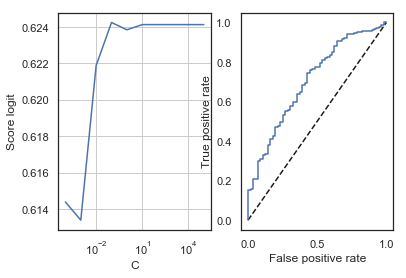

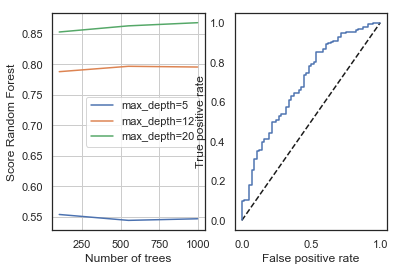

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [21]:
y_prob_val_lg, y_pred_val_lg, y_prob_test_lg, y_pred_test_lg =logit_model(X_train_pca, X_val_pca, y_train_pca['P1'], y_val_pca['P1'], X_test_pca, scoring)

y_prob_val_rf, y_pred_val_rf, y_prob_test_rf, y_pred_test_rf =rfc_model(X_train_pca, X_val_pca, y_train_pca['P1'], y_val_pca['P1'], X_test_pca, scoring)


In [22]:
best_weights, best_threshold = ensemble_model(y_val['P1'], y_prob_val_lg[:,1], y_prob_val_rf[:,1], 0, num_iterations=1000, metric="F1", text =False)

P_final = y_prob_test_lg[:,1]*best_weights[0][0] + y_prob_test_rf[:,1]*best_weights[0][1]

P1 = [int(v >= best_threshold) for v in P_final]

Best F1 score 0.6512635379061371
Model contributions: 
logit:  0.7169722234142081
random forest:  0.28302777658579187


### 4.2 P2 : Prediction that the price will go up or down (using only rf, year and industryFF12)

(7834, 200)
7834
AUC score Logit is : 0.6367481203007518
              precision    recall  f1-score   support

           0       0.26      0.48      0.34        56
           1       0.87      0.71      0.78       266

    accuracy                           0.67       322
   macro avg       0.56      0.60      0.56       322
weighted avg       0.76      0.67      0.71       322

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


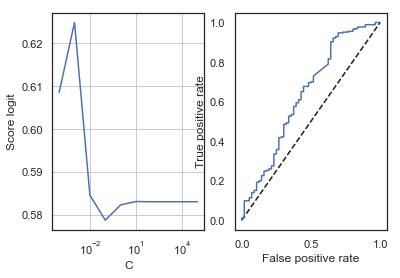

In [23]:
X_train_w2v, y_train_w2v, X_val_w2v, y_val_w2v, X_test_w2v = word2vec(X_train_rf, y_train['P2'], X_val_rf, y_val['P2'], X_test_rf)
y_prob_val_text, y_pred_val_text, y_prob_test_text, y_pred_test_text =logit_model(X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v, X_test_w2v, scoring)
    
features_industry = [c for c in X_train.columns if c.startswith("industryFF12")]  
 

(7834, 12)
7834
AUC score Logit is : 0.6052295918367346
              precision    recall  f1-score   support

           0       0.24      0.29      0.26        56
           1       0.84      0.80      0.82       266

    accuracy                           0.71       322
   macro avg       0.54      0.55      0.54       322
weighted avg       0.74      0.71      0.72       322

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
(7834, 12)
7834
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   49.5s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.0min finished


AUC score Random Forest is : 0.6100295381310419
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.83      1.00      0.90       266

    accuracy                           0.83       322
   macro avg       0.41      0.50      0.45       322
weighted avg       0.68      0.83      0.75       322



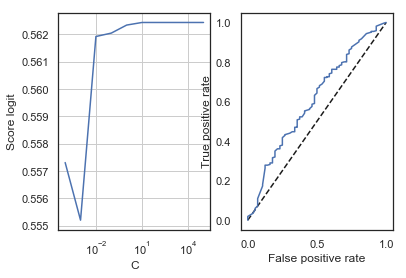

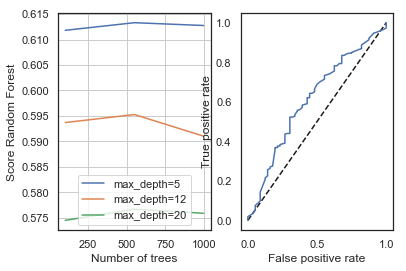

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [24]:
features_industry.append('year')
X_train_p2 = X_train[features_industry]
X_val_p2 = X_val[features_industry]
X_test_p2 =  X_test[features_industry]

y_prob_val_lg_indust, y_pred_val_lg_indust, y_prob_test_lg_indust, y_pred_test_lg_indust =logit_model(X_train_p2, X_val_p2, y_train['P2'], y_val['P2'], X_test_p2, scoring)

y_prob_val_rf_indust, y_pred_val_rf_indust, y_prob_test_rf_indust, y_pred_test_rf_indust =rfc_model(X_train_p2, X_val_p2, y_train['P2'], y_val['P2'], X_test_p2, scoring)
    

In [25]:
best_weights, best_threshold = ensemble_model(y_val['P2'], y_prob_val_lg_indust[:,1], y_prob_val_rf_indust[:,1], y_prob_val_text[:,1], num_iterations=500, metric=scoring, text =True)

P_final = y_prob_test_lg[:,1]*best_weights[0][0] + y_prob_test_rf[:,1]*best_weights[0][1] + y_prob_test_text[:,1]*best_weights[0][2]

P2 = [int(v >= best_threshold) for v in P_final]

Best F1 score 0.6510794365257981
Model contributions: 
logit:  0.15299557153020094
random forest:  0.037382290056299394
text:  0.8096221384134997


### 4.3 P3 : Prediction that the price will go up or down (using all features)

In [26]:
best_weights, best_threshold = ensemble_model(y_val['P3'], y_prob_val_lg[:,1], y_prob_val_rf[:,1], y_prob_val_text[:,1], num_iterations=100, metric=scoring, text =True)

P_final = y_prob_test_lg[:,1]*best_weights[0][0] + y_prob_test_rf[:,1]*best_weights[0][1]  + y_prob_test_text[:,1]*best_weights[0][2]

P3 = [int(v >= best_threshold) for v in P_final]

Best F1 score 0.6870748299319728
Model contributions: 
logit:  0.02671736618838092
random forest:  0.5883827510501726
text:  0.38489988276144654


### 4.4 P4 : Prediction that the price will go up by 20 % or more

(6753, 81)
6753
AUC score Logit is : 0.7876275510204082
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       224
           1       0.58      0.69      0.63        98

    accuracy                           0.75       322
   macro avg       0.71      0.74      0.72       322
weighted avg       0.77      0.75      0.76       322

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
(6753, 81)
6753
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  2.8min remaining:   20.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.3min finished


AUC score Random Forest is : 0.8256650874635568
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       224
           1       0.74      0.52      0.61        98

    accuracy                           0.80       322
   macro avg       0.78      0.72      0.74       322
weighted avg       0.79      0.80      0.79       322



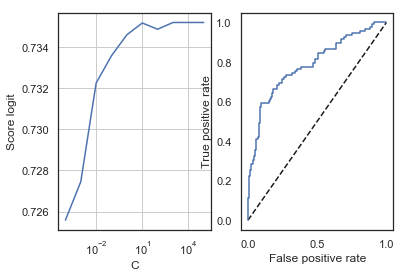

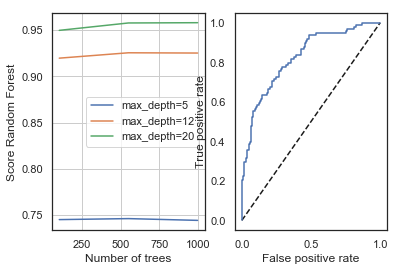

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
(6753, 200)
6753
AUC score Logit is : 0.7619123542274053
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       224
           1       0.56      0.59      0.58        98

    accuracy                           0.74       322
   macro avg       0.69      0.70      0.69       322
weighted avg       0.74      0.74      0.74       322

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=

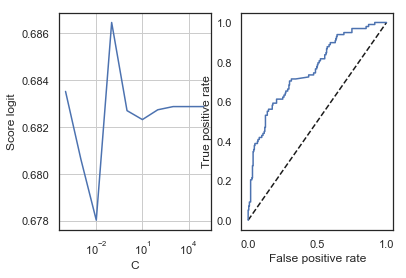

In [28]:
scoring = make_scorer(sklearn.metrics.f1_score, average = "macro")

y_prob_val_lg, y_pred_val_lg, y_prob_test_lg, y_pred_test_lg =logit_model(X_train_pca, X_val_pca, y_train_pca['P4'], y_val_pca['P4'], X_test_pca, scoring)

y_prob_val_rf, y_pred_val_rf, y_prob_test_rf, y_pred_test_rf =rfc_model(X_train_pca, X_val_pca, y_train_pca['P4'], y_val_pca['P4'], X_test_pca, scoring)


X_train_w2v, y_train_w2v, X_val_w2v, y_val_w2v, X_test_w2v = word2vec(X_train_rf, y_train['P4'], X_val_rf, y_val['P4'], X_test_rf)
y_prob_val_text, y_pred_val_text, y_prob_test_text, y_pred_test_text =logit_model(X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v, X_test_w2v, scoring)
    
    
best_weights, best_threshold = ensemble_model(y_val['P4'], y_prob_val_lg[:,1], y_prob_val_rf[:,1], y_prob_val_text[:,1], num_iterations=200, metric="F1", text=True)

P_final = y_prob_test_lg[:,1]*best_weights[0][0] + y_prob_test_rf[:,1]*best_weights[0][1]  + y_prob_test_text[:,1]*best_weights[0][2]

P4 = [int(v >= best_threshold) for v in P_final]

### 4.5 P5 : Prediction that the price will go down by 20 % or more


(8630, 81)
8630
AUC score Logit is : 0.8703124999999999
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       320
           1       0.02      0.50      0.04         2

    accuracy                           0.85       322
   macro avg       0.51      0.68      0.48       322
weighted avg       0.99      0.85      0.91       322

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
(8630, 81)
8630
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  2.5min remaining:   18.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.9min finished


AUC score Random Forest is : 0.9812500000000001
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       320
           1       0.00      0.00      0.00         2

    accuracy                           0.99       322
   macro avg       0.50      0.50      0.50       322
weighted avg       0.99      0.99      0.99       322



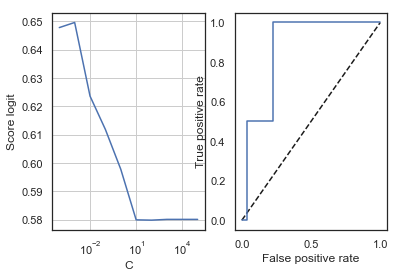

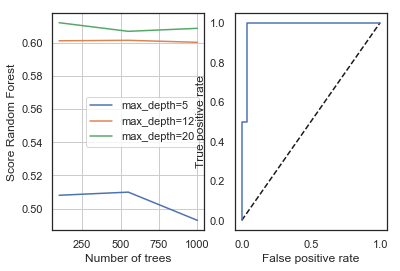

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
(8630, 200)
8630
AUC score Logit is : 0.8390625
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       320
           1       0.09      0.50      0.15         2

    accuracy                           0.97       322
   macro avg       0.54      0.73      0.57       322
weighted avg       0.99      0.97      0.98       322

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, m

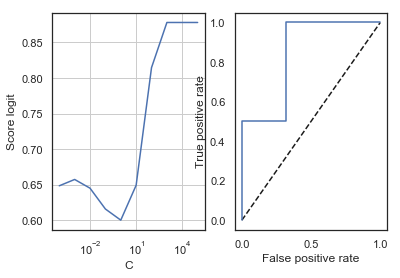

In [29]:
# Scoring methods
scoring = make_scorer(sklearn.metrics.f1_score, average = "macro")

y_prob_val_lg, y_pred_val_lg, y_prob_test_lg, y_pred_test_lg =logit_model(X_train_pca, X_val_pca, y_train_pca['P5'], y_val_pca['P5'], X_test_pca, scoring)

y_prob_val_rf, y_pred_val_rf, y_prob_test_rf, y_pred_test_rf =rfc_model(X_train_pca, X_val_pca, y_train_pca['P5'], y_val_pca['P5'], X_test_pca, scoring)


X_train_w2v, y_train_w2v, X_val_w2v, y_val_w2v, X_test_w2v = word2vec(X_train_rf, y_train['P5'], X_val_rf, y_val['P5'], X_test_rf)
y_prob_val_text, y_pred_val_text, y_prob_test_text, y_pred_test_text =logit_model(X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v, X_test_w2v, scoring)
    
    
best_weights, best_threshold = ensemble_model(y_val['P5'], y_prob_val_lg[:,1], y_prob_val_rf[:,1], y_prob_val_text[:,1], num_iterations=200, metric=scoring, text =True)

P_final = y_prob_test_lg[:,1]*best_weights[0][0] + y_prob_test_rf[:,1]*best_weights[0][1]  + y_prob_test_text[:,1]*best_weights[0][2]

P5 = [int(v >= best_threshold) for v in P_final]

### 4.6 P6 : Prediction of the price itself

The metric we will use here is the mean square error. We will compare a linear regressor to a random forest regressor and choose the best one for our P6 predictions.

In [68]:
print("no pca: ")
P_random_forest = random_forest_regressor(X_train, X_val, y_train['P6'], y_val['P6'], X_test)
P_lin_reg = linear_regressor(X_train, X_val, y_train['P6'], y_val['P6'], X_test)
print("pca: ")
P_random_forest_pca = random_forest_regressor(X_train_pca, X_val_pca, y_train_pca['P6'], y_val_pca['P6'], X_test_pca)
P_lin_reg_pca = linear_regressor(X_train_pca, X_val_pca, y_train_pca['P6'], y_val_pca['P6'], X_test_pca)

no pca: 
The random forest regressor confidence is  0.8066767304927436
Root mean square error is  5.74030350220038
The linear regression confidence is  0.6290018651351631
Root mean square error is  7.952041768331514
pca: 
The random forest regressor confidence is  0.6294295668539523
Root mean square error is  7.947456728125068
The linear regression confidence is  0.6289190717934583
Root mean square error is  7.95292902263576


In [69]:
P6 = P_random_forest

### 4.7 P7 : Probability that the price will go up by 5 % or more

The metric we will use here to get the best prediction is the following one:
If proba P turns out to be FALSE, the score is P * P
If proba P turns out to be TRUE, the score is (100-P)*(100-P)
For each predictions, we will try to minimize the score

P.S: the values on the plots are negative because the optimizer actualy maximizes the negative values instead of minimizing the real positive values.
                      

(6982, 81)
6982
AUC score Logit is : 0.7011710163462691
              precision    recall  f1-score   support

           0       0.57      0.64      0.60       131
           1       0.73      0.66      0.70       191

    accuracy                           0.66       322
   macro avg       0.65      0.65      0.65       322
weighted avg       0.66      0.66      0.66       322

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
(6982, 81)
6982
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  2.3min remaining:   17.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.8min finished


AUC score Random Forest is : 0.7072459134327165
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       131
           1       0.73      0.63      0.68       191

    accuracy                           0.64       322
   macro avg       0.64      0.64      0.64       322
weighted avg       0.66      0.64      0.65       322



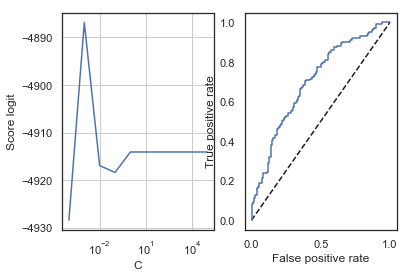

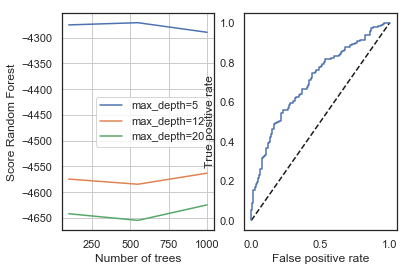

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
(6982, 200)
6982
AUC score Logit is : 0.6596458974461452
              precision    recall  f1-score   support

           0       0.52      0.70      0.60       131
           1       0.73      0.55      0.63       191

    accuracy                           0.61       322
   macro avg       0.63      0.63      0.61       322
weighted avg       0.65      0.61      0.62       322

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=No

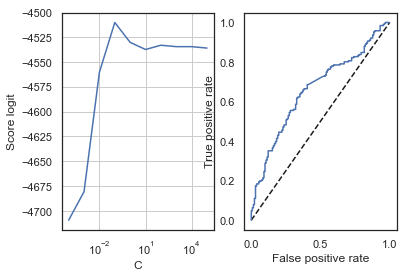

In [52]:
def p7_score(y_true, y_prob) :
    s = 0
    for i in range(len(y_true)) :
        if(y_true.iloc[i] == 0) : # true value is false
            s += ((100*y_prob[i]) ** 2)
        elif(y_true.iloc[i] == 1) :
            s += ((100*y_prob[i])**2)
        else :
            print("FORMAT ERROR ! Y_true is not binary")
            return
    
    return s/len(y_true)

scoring = make_scorer(p7_score,greater_is_better =False)

y_prob_val_lg, y_pred_val_lg, y_prob_test_lg, y_pred_test_lg =logit_model(X_train_pca, X_val_pca, y_train_pca['P7'], y_val_pca['P7'], X_test_pca, scoring)

y_prob_val_rf, y_pred_val_rf, y_prob_test_rf, y_pred_test_rf =rfc_model(X_train_pca, X_val_pca, y_train_pca['P7'], y_val_pca['P7'], X_test_pca, scoring)


X_train_w2v, y_train_w2v, X_val_w2v, y_val_w2v, X_test_w2v = word2vec(X_train_rf, y_train['P7'], X_val_rf, y_val['P7'], X_test_rf)
y_prob_val_text, y_pred_val_text, y_prob_test_text, y_pred_test_text =logit_model(X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v, X_test_w2v, scoring)
    
 

In [55]:
best_weights, best_threshold = ensemble_model(y_val['P7'], y_prob_val_lg[:,1], y_prob_val_rf[:,1], y_prob_val_text[:,1], num_iterations=200, metric="p7", text =True)

P7 = y_prob_test_lg[:,1]*best_weights[0][0] + y_prob_test_rf[:,1]*best_weights[0][1]  + y_prob_test_text[:,1]*best_weights[0][2]


Best p7 metric score 2624.4760478929975
Model contributions: 
logit:  5.0430765632080105e-05
random forest:  0.5748850672847948
text:  0.425064501949573


### 4.8 P8 : Probability that the price will go up by 50 % or more

AUC score Logit is : 0.8265441176470588
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       272
           1       0.70      0.38      0.49        50

    accuracy                           0.88       322
   macro avg       0.80      0.68      0.71       322
weighted avg       0.87      0.88      0.86       322

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   18.9s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   22.2s finished


AUC score Random Forest is : 0.8638235294117648
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       272
           1       0.92      0.24      0.38        50

    accuracy                           0.88       322
   macro avg       0.90      0.62      0.66       322
weighted avg       0.88      0.88      0.85       322



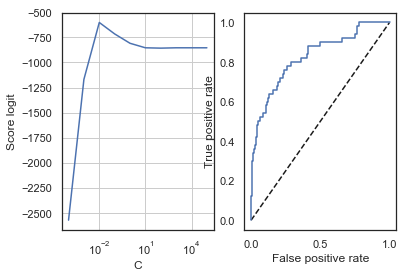

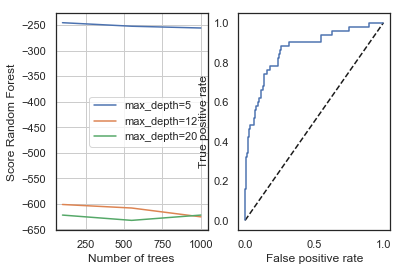

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
AUC score Logit is : 0.8283823529411765
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       272
           1       0.62      0.26      0.37        50

    accuracy                           0.86       322
   macro avg       0.75      0.62      0.64       322
weighted avg       0.84      0.86      0.84       322

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100

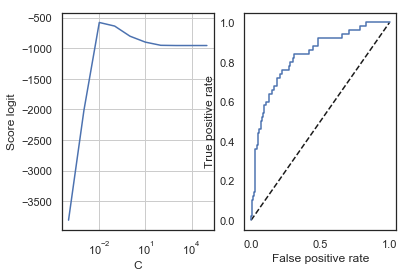

In [72]:
scoring = make_scorer(p7_score,greater_is_better =False)

y_prob_val_lg, y_pred_val_lg, y_prob_test_lg, y_pred_test_lg =logit_model(X_train, X_val, y_train['P8'], y_val['P8'], X_test, scoring)

y_prob_val_rf, y_pred_val_rf, y_prob_test_rf, y_pred_test_rf =rfc_model(X_train, X_val, y_train['P8'], y_val['P8'], X_test, scoring)


X_train_w2v, y_train_w2v, X_val_w2v, y_val_w2v, X_test_w2v = word2vec(X_train_rf, y_train['P8'], X_val_rf, y_val['P8'], X_test_rf)
y_prob_val_text, y_pred_val_text, y_prob_test_text, y_pred_test_text =logit_model(X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v, X_test_w2v, scoring)
    
    
best_weights, best_threshold = ensemble_model(y_val['P8'], y_prob_val_lg[:,1], y_prob_val_rf[:,1], y_prob_val_text[:,1], num_iterations=200, metric="p7", text =True)

P8 = y_prob_test_lg[:,1]*best_weights[0][0] + y_prob_test_rf[:,1]*best_weights[0][1]  + y_prob_test_text[:,1]*best_weights[0][2]


### 4.9 P9 : Probability that the price will go down by 20 % or more

The metric we will use here is the following one:
If proba P turns out to be FALSE, the error score is 100*P
If proba P turns out to be TRUE, the error score is 2*(100-p)
For each predictions, we will try to minimize the score
                      

In [73]:
def p9_score(y_true, y_prob) :
    
    s=0
    for i in range(len(y_true)) :
        if(y_true.iloc[i] == 0) : # true value is false
            s += 100*y_prob[i]
        elif(y_true.iloc[i] == 1) :
            s += 2*(100*y_prob[i])
        else :
            print("FORMAT ERROR ! Y_true is not binary")
            return
    
    return s/len(y_true)

AUC score Logit is : 0.6165863066538091
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       305
           1       0.00      0.00      0.00        17

    accuracy                           0.95       322
   macro avg       0.47      0.50      0.49       322
weighted avg       0.90      0.95      0.92       322

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   18.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   21.4s finished


AUC score Random Forest is : 0.6815814850530376
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       305
           1       0.00      0.00      0.00        17

    accuracy                           0.95       322
   macro avg       0.47      0.50      0.49       322
weighted avg       0.90      0.95      0.92       322



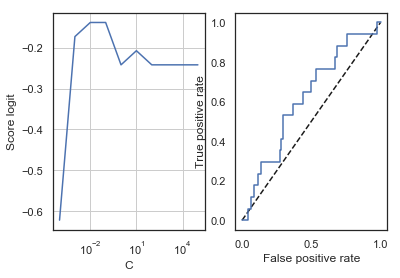

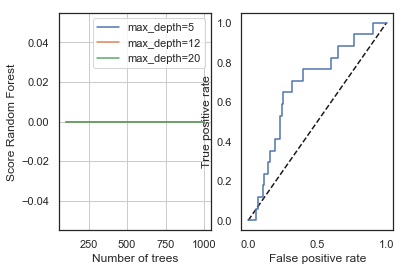

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
AUC score Logit is : 0.5464802314368371
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       305
           1       0.00      0.00      0.00        17

    accuracy                           0.95       322
   macro avg       0.47      0.50      0.49       322
weighted avg       0.90      0.95      0.92       322

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10

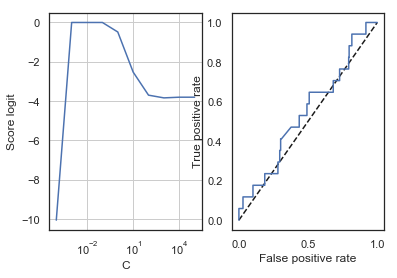

In [74]:
scoring = make_scorer(p9_score, greater_is_better = False)

y_prob_val_lg, y_pred_val_lg, y_prob_test_lg, y_pred_test_lg =logit_model(X_train, X_val, y_train['P9'], y_val['P9'], X_test, scoring)

y_prob_val_rf, y_pred_val_rf, y_prob_test_rf, y_pred_test_rf =rfc_model(X_train, X_val, y_train['P9'], y_val['P9'], X_test, scoring)

X_train_w2v, y_train_w2v, X_val_w2v, y_val_w2v, X_test_w2v = word2vec(X_train_rf, y_train['P9'], X_val_rf, y_val['P9'], X_test_rf)
y_prob_val_text, y_pred_val_text, y_prob_test_text, y_pred_test_text =logit_model(X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v, X_test_w2v, scoring)
  

In [75]:
best_weights, best_threshold = ensemble_model(y_val['P9'], y_prob_val_lg[:,1], y_prob_val_rf[:,1], y_prob_val_text[:,1], num_iterations=200, metric="p9", text=True)

P9 = y_prob_test_lg[:,1]*best_weights[0][0] + y_prob_test_rf[:,1]*best_weights[0][1] + y_prob_test_text[:,1]*best_weights[0][2]


Best p9 metric score 5.246294207958559
Model contributions: 
logit:  0.00806460075165027
random forest:  0.9903452064261558
text:  0.0015901928221940794


## 5. Results

Throughout all the predicitons of the previous section, a detail of the models was displayed. We observed the AUC score of the models for each predictions. This allowed us to deduct that our models were better than dummy classifiers. 
We also observed how the ensemble model combines the probabilities outputed by the models to suggest a better overall prediction.

Very interestingly, from one prediction to another, it changes a lot. 
For exemple, P9 relies by 99 % on the text model while P3 has a good repartition of the models (logit:  26%, random forest:  58%, text:  38% ).

We also predicted the closing price using a random forest regressor and the MSE we observed on the validation is quite encouraging.

Below is the table which recaps the result that we have gotten while running this notebook first with normal Data, second with PCA data and lastly with Augmented PCA data. We recap the best F1 score for each predictions.

Using PCA mainly helped for the first classification tasks while adding augmentation do not show clear improvements. Some other predictions appeared better using the normal data with no fancy transformation.

<img src="images/image1.png" style="height:400px"> 

## 6. Conclusion

Throughout our projet, we explored and studied different machine learning models and data processing strategies to come up with the best automated tool to price IPOs. 

Although our models performance are relatively good, it is still **not satisfying enough to solely rely on them** for a quite sensitive task, i.e, making a quite impactful financial decision regarding a whole company. 
While machine learning for economical models can tell us how things would look like given our previous experience and how likely is a given outcome, because an IPO is always something new, when a company goes for an IPO there is no previous experience like this one, making this process highly stochastic and unpredictable. Hence, every IPO should be analyzed more carefully than other statistics-based model because they consist of expected values and approximations and stakes are quite high. Indeed, accurately pricing an IPO would suggest there exists some ground truth about its effective value, which is not the case, as it highly **depends on how good a company is at its job in its domain and how suitable its business model is for the market**, among multiples unpredictable other factors.

However, even if investment banks should not solely rely on these automated tools, they are **still useful** as they are able to **filter and extract obvious opportunities** among a whole lot of them, which may end up in **saving a huge amount of time and money**.

Finally, while our previous comments brought shades to our machine learning models performance, it is important to note here that the presented models are traditional and simple ones. Indeed, **state-of-the-art machine learning models** currently used in the market highly **outperform ours**. Among them, given more time at our disposal, we could have tried advanced deep learning model such as deep recurrent networks, generative models such as GANs or auto-encoders or even mixed combinations of the most recent architectures in the machine learning litterature.

One obvious **downside** in using these kind of models is their **high complexity** in understanding easily how they function. For this reason, because we are in sensitive area, i.e stock market, which involves huge amounts of money, company representative or decision makers may **be less inclined in allowing these kind of methods to be used** if themselves can't really understand the underlying techniques to make the decision.

In [76]:
path_test = "IPO_data_to_predict.xlsx"
data_to_predict = pd.read_excel(path_test, index_col=0)

data_to_predict['P1'] = P1
data_to_predict['P2'] = P2
data_to_predict['P3'] = P3
data_to_predict['P4'] = P4
data_to_predict['P5'] = P5
data_to_predict['P6'] = P6
data_to_predict['P7'] = P7
data_to_predict['P8'] = P8
data_to_predict['P9'] = P9

data_to_predict.to_excel("IPO_data_to_predict.xlsx")